<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 Support Vector Machines

## Understanding the Problem  
We are working on classifying handwritten digits using the MNIST dataset. Each image in this dataset is 28x28 pixels, and the data is provided in CSV format, where each row represents a flattened grayscale image.  

## Dataset Overview  
- **Size:** 60,000 rows × 785 columns  
- **First Column:** The label (y), representing digits from 0 to 9  
- **Next 784 Columns:** Pixel values (X), indicating grayscale intensities  
- **Pixel Range:** 0 to 255 (normalized to 0-1 for better model performance)  

For this task, we will train a Support Vector Machine (SVM) using Stochastic Gradient Descent (SGD), which is well-suited for large datasets like MNIST.


Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=dbd0c9db-2c32-4c54-90c9-f032bd9d2eab
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 41.5MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


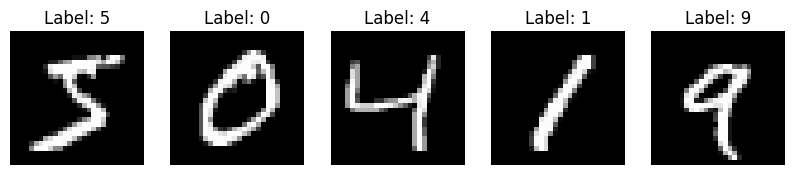

In [ ]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#----------------------------------------------------------------------
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

### 📚 Custom Multi-Class SVM using Stochastic Gradient Descent (SGD)

This notebook implements a **custom Support Vector Machine (SVM)** from scratch to handle **multi-class classification**, specifically tailored for the **MNIST dataset (digits 0–9)**. Instead of using built-in libraries, we train the model manually for better understanding and control.

---

### 🔍 Conceptual Overview

Support Vector Machines are powerful linear classifiers that aim to **maximize the margin** between data points and the decision boundary. Since traditional SVMs are binary classifiers, we extend them to multi-class settings using the **One-vs-All (OvA)** strategy:

> For each class \( c \), train a binary classifier to distinguish **class \( c \)** from **all other classes**.

This results in **K binary classifiers** for a K-class problem (K = 10 for MNIST). During prediction, we select the class with the **highest confidence score**.

---

### ✏️ Mathematical Formulation

We use the **Hinge Loss** function with **L2 regularization**, optimized using **Mini-Batch Stochastic Gradient Descent (SGD)**.

#### 🧮 Hinge Loss (Binary):

For a sample $ (x_i, y_i) $, where $ y_i \in \{+1, -1\} $:

$$
L_i = \max(0, 1 - y_i (w^\top x_i + b))
$$

#### 🧮 Regularized Objective Function:

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} L_i + \lambda \|w\|^2
$$

Where:  
-  $w $ is the weight vector  
- $ b $  is the bias  
- $ \lambda $ is the regularization parameter (to prevent overfitting)  
- $ m $  is the number of training samples in the batch

#### 🧮 Gradient Computation (for misclassified points):

$$
\nabla_w = 2\lambda w - \sum y_i x_i
$$

$$
\nabla_b = -\sum y_i
$$

#### 🧮 Weight Updates:

$$
w := w - \eta \cdot \frac{\nabla_w}{\text{batch_size}}
$$

$$
b := b - \eta \cdot \frac{\nabla_b}{\text{batch_size}}
$$

Where $\\eta \$ is the learning rate.

---

### ⚙️ Why Build from Scratch?

- **Custom Control**: Direct control over learning rate, regularization, and batch size  
- **Scalability**: Trains effectively on large datasets using mini-batch updates  
- **Educational Insight**: Deepens understanding of the SVM training pipeline and gradient-based optimization  


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
class FastMultiClassSVM:
    def __init__(self, learning_rate=0.015, lambda_param=0.008, epochs=750, batch_size=256):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes = None
        self.models = {}  # Dictionary to store (W, b) for each class

    def fit(self, X, y):
        """Train SVM using Mini-Batch SGD (One-vs-All)."""
        self.classes = np.unique(y)  # Unique digit labels (0-9)
        m, n = X.shape  # Samples, Features

        for digit in self.classes:
            print(f"Training for digit {digit}...")
            y_binary = np.where(y == digit, 1, -1)  # Convert labels to {+1, -1}

            W = np.zeros(n)  # Initialize weights
            b = 0  # Initialize bias

            for epoch in range(self.epochs):
                indices = np.random.permutation(m)  # Shuffle data each epoch
                X_shuffled, y_shuffled = X[indices], y_binary[indices]

                for batch_start in range(0, m, self.batch_size):
                    batch_end = batch_start + self.batch_size
                    X_batch = X_shuffled[batch_start:batch_end]
                    y_batch = y_shuffled[batch_start:batch_end]

                    # Compute margins for the batch
                    margins = y_batch * (np.dot(X_batch, W) + b)
                    misclassified = margins < 1  # Boolean mask for misclassified points

                    # Compute gradients
                    W_gradient = 2 * self.lambda_param * W - np.dot(y_batch[misclassified], X_batch[misclassified])
                    b_gradient = -np.sum(y_batch[misclassified])

                    # Update weights
                    W -= self.learning_rate * W_gradient / self.batch_size
                    b -= self.learning_rate * b_gradient / self.batch_size

                if epoch % 100 == 0:
                    print(f"Epoch {epoch}/{self.epochs} completed")

            self.models[digit] = (W, b)  # Store trained model

    def predict(self, X):
        """Predict class labels using One-vs-All strategy."""
        scores = np.zeros((X.shape[0], len(self.classes)))  # Store decision scores

        for i, digit in enumerate(self.classes):
            W, b = self.models[digit]
            scores[:, i] = np.dot(X, W) + b  # Compute scores for each class

        return self.classes[np.argmax(scores, axis=1)]  # Pick class with highest score


In [ ]:
learning_rates = [0.01, 0.015, 0.02, 0.05]
lr_accuracies = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    svm = FastMultiClassSVM(learning_rate=lr, epochs=500, batch_size=256)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    lr_accuracies.append(acc)
    print(f"Test Accuracy: {acc:.4f}")



Training with learning rate: 0.01
Training for digit 0...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 1...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 2...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 3...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 4...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 5...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 completed
Epoch 400/500 completed
Training for digit 6...
Epoch 0/500 completed
Epoch 100/500 completed
Epoch 200/500 completed
Epoch 300/500 compl

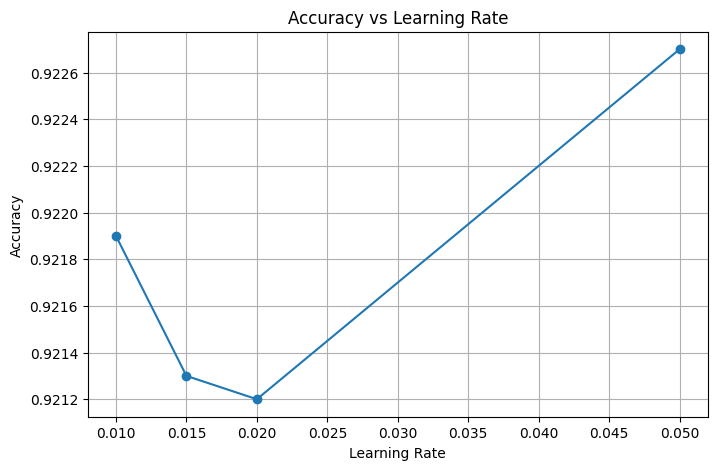

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(learning_rates, lr_accuracies, marker='o')
plt.title("Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
epoch_list = [300, 500, 750, 1000]
epoch_accuracies = []

for ep in epoch_list:
    print(f"\nTraining with epochs: {ep}")
    svm = FastMultiClassSVM(learning_rate=0.015, epochs=ep, batch_size=256)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    epoch_accuracies.append(acc)
    print(f"Test Accuracy: {acc:.4f}")



Training with epochs: 300
Training for digit 0...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 1...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 2...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 3...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 4...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 5...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 6...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 7...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 8...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Training for digit 9...
Epoch 0/300 completed
Epoch 100/300 completed
Epoch 200/300 completed
Test Accuracy: 0.9210

Training w

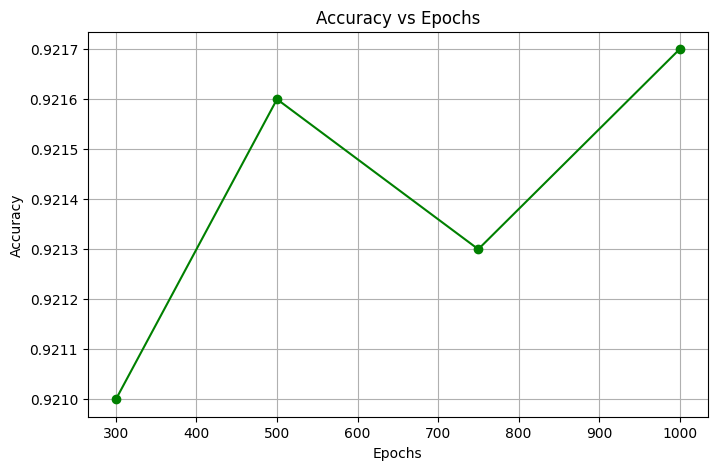

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epoch_list, epoch_accuracies, marker='o', color='green')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
best_index = np.argmax(epoch_accuracies)
best_epochs = epoch_list[best_index]
print(f"Retraining final model with best epoch count: {best_epochs}")

final_model = FastMultiClassSVM(learning_rate=0.015, epochs=best_epochs, batch_size=256)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)


Retraining final model with best epoch count: 1000
Training for digit 0...
Epoch 0/1000 completed
Epoch 100/1000 completed
Epoch 200/1000 completed
Epoch 300/1000 completed
Epoch 400/1000 completed
Epoch 500/1000 completed
Epoch 600/1000 completed
Epoch 700/1000 completed
Epoch 800/1000 completed
Epoch 900/1000 completed
Training for digit 1...
Epoch 0/1000 completed
Epoch 100/1000 completed
Epoch 200/1000 completed
Epoch 300/1000 completed
Epoch 400/1000 completed
Epoch 500/1000 completed
Epoch 600/1000 completed
Epoch 700/1000 completed
Epoch 800/1000 completed
Epoch 900/1000 completed
Training for digit 2...
Epoch 0/1000 completed
Epoch 100/1000 completed
Epoch 200/1000 completed
Epoch 300/1000 completed
Epoch 400/1000 completed
Epoch 500/1000 completed
Epoch 600/1000 completed
Epoch 700/1000 completed
Epoch 800/1000 completed
Epoch 900/1000 completed
Training for digit 3...
Epoch 0/1000 completed
Epoch 100/1000 completed
Epoch 200/1000 completed
Epoch 300/1000 completed
Epoch 400/1

In [ ]:
acc_final = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Test Accuracy: {acc_final:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final))



Final Test Accuracy: 0.9216

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.90      0.94      0.92       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.88      0.87      0.87       974
           9       0.91      0.88      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



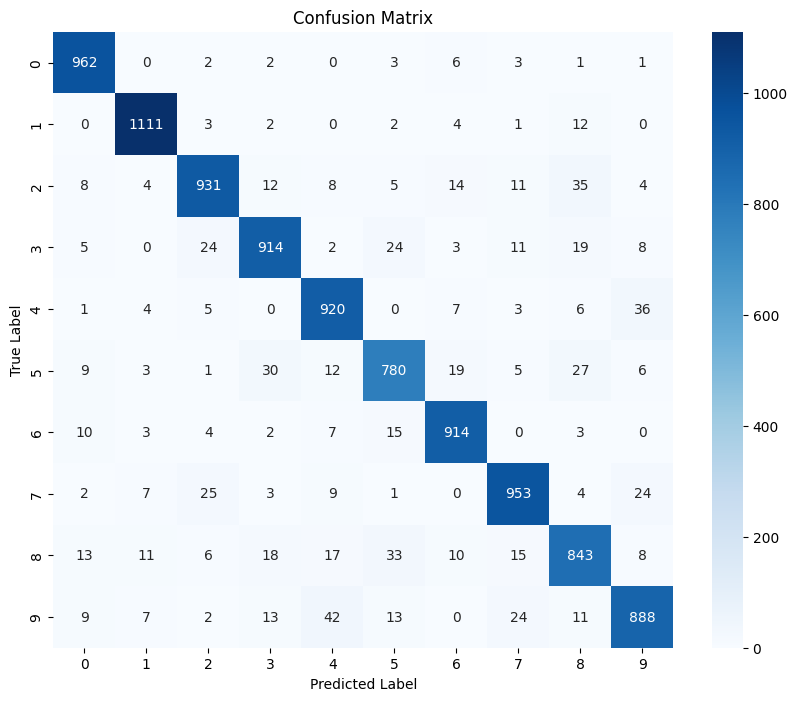

In [ ]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


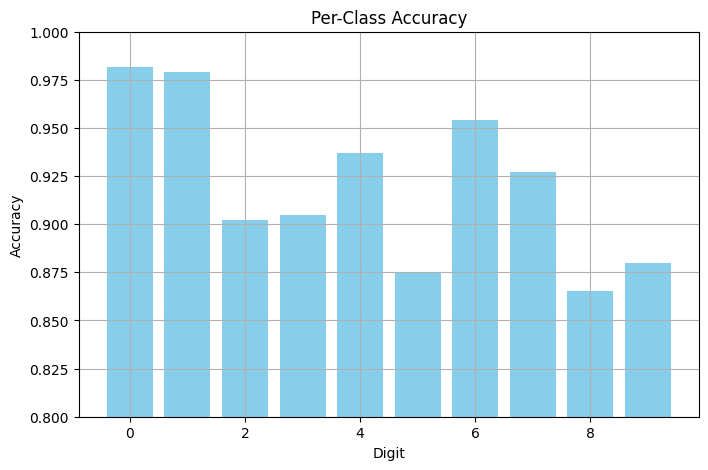

In [ ]:
correct = y_pred_final == y_test
digit_accuracies = []

for digit in range(10):
    indices = np.where(y_test == digit)[0]
    acc = np.mean(correct[indices])
    digit_accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.bar(range(10), digit_accuracies, color='skyblue')
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.show()


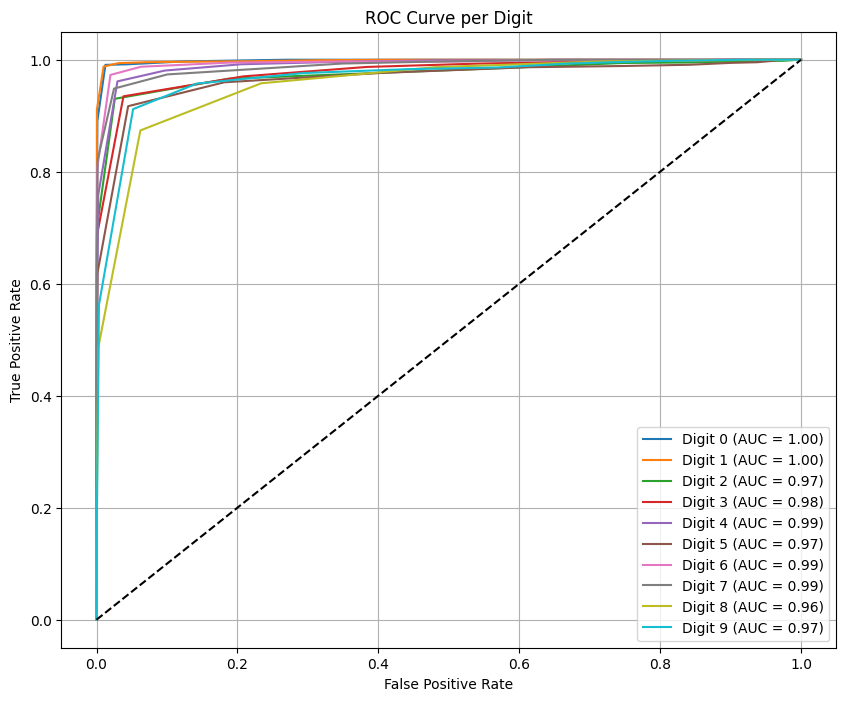

In [ ]:
# Binarize labels for ROC
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=range(10))
y_scores = np.zeros_like(y_test_bin)

# Get scores from final model
for i, digit in enumerate(range(10)):
    W, b = final_model.models[digit]
    y_scores[:, i] = np.dot(X_test, W) + b

# Plot ROC curves
plt.figure(figsize=(10,8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Digit {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Digit")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Note: Till Now We have achived a maximum acccuracy of 92.16% using the SGD Variant. Now We will apply Random Fourier Features, and lets see what happens !!!

In [1]:
!pip install gdown scikit-learn matplotlib seaborn


Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=84909225-4e40-4938-b25f-9f2003deb662
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 75.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 56.9MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


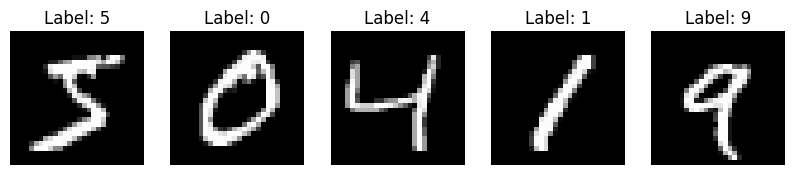

In [2]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#----------------------------------------------------------------------
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

gammas = [0.01, 0.05, 0.1, 0.5]
n_components_list = [500, 1000, 2000, 3000]

results = []

print("Training models with different gamma and n_components...\n")

for gamma in gammas:
    for n_components in n_components_list:
        print(f"Training with gamma={gamma}, n_components={n_components}...", end=" ")

        rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=42)
        X_train_rff = rbf_feature.fit_transform(X_train)
        X_test_rff = rbf_feature.transform(X_test)

        clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
        clf.fit(X_train_rff, y_train)

        y_pred = clf.predict(X_test_rff)
        acc = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {acc:.4f}")

        results.append({
            "gamma": gamma,
            "n_components": n_components,
            "accuracy": acc
        })

results_df = pd.DataFrame(results)

# Print best
best_row = results_df.loc[results_df['accuracy'].idxmax()]
best_gamma = best_row['gamma']
best_n_components = best_row['n_components']
best_accuracy = best_row['accuracy']

print("\n=== Results Summary ===")
print(results_df.sort_values(by="accuracy", ascending=False))
print(f"\nBest Parameters → gamma: {best_gamma}, n_components: {best_n_components}, Accuracy: {best_accuracy:.4f}")


Training models with different gamma and n_components...

Training with gamma=0.01, n_components=500... Test Accuracy: 0.9285
Training with gamma=0.01, n_components=1000... Test Accuracy: 0.9449
Training with gamma=0.01, n_components=2000... Test Accuracy: 0.9516
Training with gamma=0.01, n_components=3000... Test Accuracy: 0.9544
Training with gamma=0.05, n_components=500... Test Accuracy: 0.7677
Training with gamma=0.05, n_components=1000... Test Accuracy: 0.8615
Training with gamma=0.05, n_components=2000... Test Accuracy: 0.9102
Training with gamma=0.05, n_components=3000... Test Accuracy: 0.9287
Training with gamma=0.1, n_components=500... Test Accuracy: 0.3346
Training with gamma=0.1, n_components=1000... Test Accuracy: 0.4551
Training with gamma=0.1, n_components=2000... Test Accuracy: 0.5595
Training with gamma=0.1, n_components=3000... 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = results_df.pivot(index="gamma", columns="n_components", values="accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Accuracy for each gamma and n_components")
plt.xlabel("n_components")
plt.ylabel("gamma")
plt.show()


In [ ]:
# Use best gamma and n_components
best_n_components = int(best_n_components)
best_gamma = float(best_gamma)
rbf_feature = RBFSampler(gamma=best_gamma, n_components=best_n_components, random_state=42)
X_train_rff = rbf_feature.fit_transform(X_train)
X_test_rff = rbf_feature.transform(X_test)

clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_train_rff, y_train)

y_pred = clf.predict(X_test_rff)


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
accuracies = [report[str(i)]['precision'] for i in range(10)]

plt.figure(figsize=(10, 5))
plt.bar(range(10), accuracies, color="skyblue")
plt.xticks(range(10))
plt.xlabel("Digit Class")
plt.ylabel("Precision")
plt.title("Accuracy (Precision) per Class")
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize labels
y_test_bin = label_binarize(y_test, classes=range(10))

# One-vs-rest classifier
ovr_clf = OneVsRestClassifier(SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42))
ovr_clf.fit(X_train_rff, y_train)
y_score = ovr_clf.decision_function(X_test_rff)

# Plot ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
